![Cancer](https://media2.giphy.com/media/sCqnpiUFN228E/giphy.gif)

# Introduction

Among the most important areas in the world is human health. Exploring the methods for preventing and detecting health problems has sparked a lot of interest. Cancer is the most common illness that has a significant impact on human health. A malignant tumor is a cancerous tumor that develops as a result of the disease. Colon cancer, together with breast cancer and lung cancer, is the third most deadly disease in the United States, killing 49,190 people in 2016 [1]. This is a cancer that begins in the large intestine colon, which is the last component of the digestive system.

The machine learning technique should be used in this assignment to aid in the detection of malignant cells and the differentiation of cell types in colon cancer. Deep learning algorithms such as AlexNet, Resnet50, and VGG19 will all be developed and evaluated in this notebook, with XGBoost being the sole non-deep learning option to tackle the issue.

# Import necessary library

In [40]:
conda install -c conda-forge keras-preprocessing


Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [41]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Load dataset

In [43]:
df_label = pd.read_csv("data_labels_mainData.csv")
df_label_extra = pd.read_csv("data_labels_extraData.csv")

ValueError: a must be greater than 0 unless no samples are taken

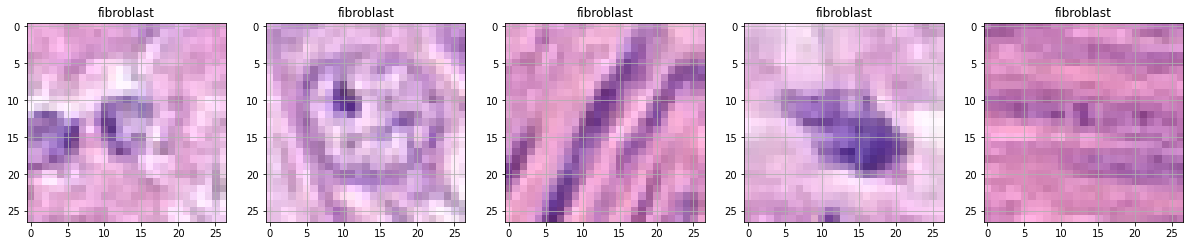

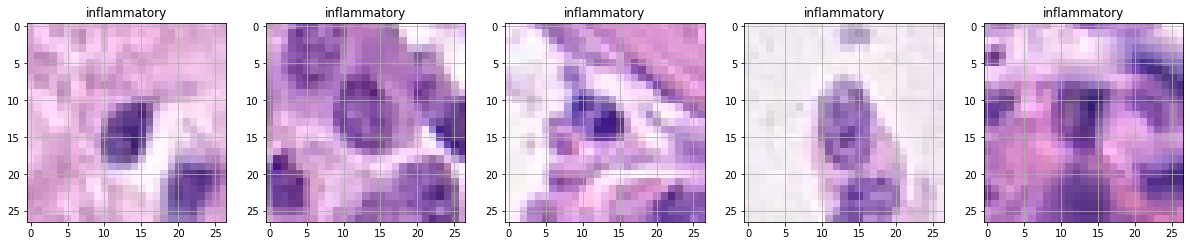

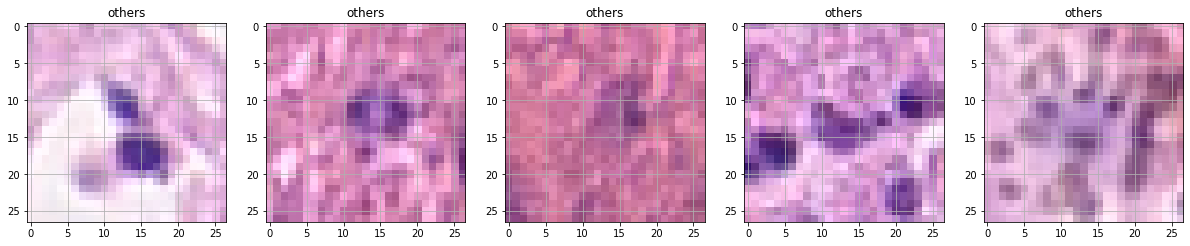

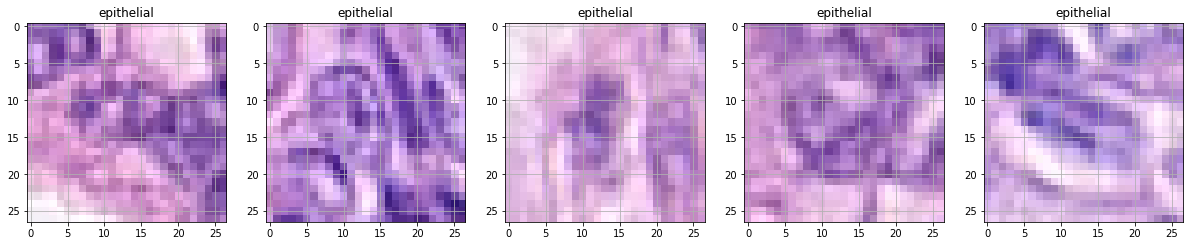

In [49]:
from tensorflow.keras.preprocessing import image

CELL_TYPE_SAMPLE_SIZE = 5

for cell_type_name in df_label['cellTypeName'].unique():
    df_sample = df_label[df_label['cellTypeName'] == cell_type_name].sample(CELL_TYPE_SAMPLE_SIZE)
    plt.figure(figsize=(CELL_TYPE_SAMPLE_SIZE ** 2, CELL_TYPE_SAMPLE_SIZE))
    for image_index, image_name in enumerate(df_sample['ImageName']):
        plt.subplot(1, CELL_TYPE_SAMPLE_SIZE + 1, image_index+1)
        plt.grid(None)
        img = image.load_img('./patch_images/' + image_name, target_size=(27, 27))
        plt.imshow(img)
        plt.title(cell_type_name)

# Data Processing 


In [44]:
is_cancer_class_count = df_label.isCancerous.value_counts()
amount_for_balance = abs(is_cancer_class_count[0] - is_cancer_class_count[1])
df_random_cancer_from_extra = df_label_extra[df_label_extra['isCancerous'] == 1].sample(amount_for_balance)
df_label = pd.concat([df_label, df_random_cancer_from_extra], ignore_index=True)
df_label.isCancerous.value_counts()

0    5817
1    5817
Name: isCancerous, dtype: int64

In [50]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_label, test_size=0.2, random_state=9999)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=9999)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_df.shape[0], val_df.shape[0], test_df.shape[0]))

Train data : 6980, Val Data: 2327, Test Data: 2327


In [51]:
# document: https://keras.io/api/preprocessing/image/#imagedatagenerator-class
from keras_preprocessing.image import ImageDataGenerator

def get_dataframe_iterator(dataframe, 
                            image_shape = (27, 27), 
                            batch_size = 64,
                            x_col = "ImageName",
                            y_col = "cellTypeName",
                            classes = ["fibroblast", "inflammatory", "epithelial", "others"]):
    dataframe[y_col] = dataframe[y_col].apply(str)
    generator = ImageDataGenerator(
        rescale = 1./255, 
        rotation_range = 20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    ) 
    iterator = generator.flow_from_dataframe(
        dataframe = dataframe,
        directory = "./patch_images", 
        x_col = x_col,
        y_col = y_col,
        classes = classes, 
        class_mode = "categorical", 
        target_size = image_shape, 
        batch_size = batch_size,
    )
    return iterator

In [52]:
# Check duplicate

In [59]:
file_list = os.listdir('./patch_images/')
print(len(file_list))

20280


In [60]:
import hashlib, os
duplicates = []
hash_keys = dict()
for index, filename in  enumerate(os.listdir('./patch_images/')):  #listdir('.') = current directory

    if os.path.isfile('./patch_images/'+filename):
        with open('./patch_images/'+filename, 'rb') as f:
            filehash = hashlib.md5(f.read()).hexdigest()
        if filehash not in hash_keys: 
            hash_keys[filehash] = index
        else:
            duplicates.append((index,hash_keys[filehash]))
            print(filename)


15848.png
18581.png
4971.png


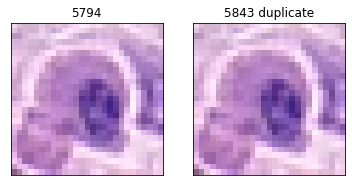

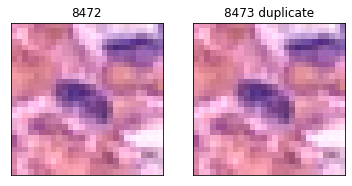

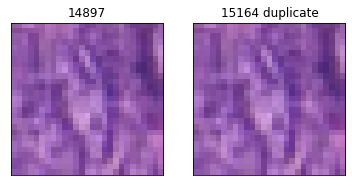

In [61]:
from imageio import imread
for file_indexes in duplicates[:30]:
    try:
    
        plt.subplot(121),plt.imshow(imread('./patch_images/'+ file_list[file_indexes[1]]))
        plt.title(file_indexes[1]), plt.xticks([]), plt.yticks([])

        plt.subplot(122),plt.imshow(imread('./patch_images/'+ file_list[file_indexes[0]]))
        plt.title(str(file_indexes[0]) + ' duplicate'), plt.xticks([]), plt.yticks([])
        plt.show()
    
    except OSError as e:
        continue

In [62]:
# # Remove duplicate
# for index in duplicates:
#     os.remove('./patch_images/'+file_list[index[0]])

In [63]:
is_cancer_class_count = df_label.isCancerous.value_counts()
amount_for_balance = abs(is_cancer_class_count[0] - is_cancer_class_count[1])
df_random_cancer_from_extra = df_label_extra[df_label_extra['isCancerous'] == 1].sample(amount_for_balance)
df_label = pd.concat([df_label, df_random_cancer_from_extra], ignore_index=True)
df_label.isCancerous.value_counts()

0    5817
1    5817
Name: isCancerous, dtype: int64

In [64]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_label, test_size=0.2, random_state=9999)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=9999)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_df.shape[0], val_df.shape[0], test_df.shape[0]))

Train data : 6980, Val Data: 2327, Test Data: 2327


In [65]:
# document: https://keras.io/api/preprocessing/image/#imagedatagenerator-class
from keras_preprocessing.image import ImageDataGenerator

def get_dataframe_iterator(dataframe, 
                            image_shape = (27, 27), 
                            batch_size = 64,
                            x_col = "ImageName",
                            y_col = "cellTypeName",
                            classes = ["fibroblast", "inflammatory", "epithelial", "others"]):
    dataframe[y_col] = dataframe[y_col].apply(str)
    generator = ImageDataGenerator(
        rescale = 1./255, 
        rotation_range = 20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    ) 
    iterator = generator.flow_from_dataframe(
        dataframe = dataframe,
        directory = "./patch_images", 
        x_col = x_col,
        y_col = y_col,
        classes = classes, 
        class_mode = "categorical", 
        target_size = image_shape, 
        batch_size = batch_size,
    )
    return iterator

In [66]:
train_iterator = get_dataframe_iterator(train_df, y_col='isCancerous', classes=['0','1'])
val_iterator = get_dataframe_iterator(val_df, y_col='isCancerous', classes=['0','1'])
test_iterator = get_dataframe_iterator(test_df, y_col='isCancerous', classes=['0','1'])

Found 6980 validated image filenames belonging to 2 classes.
Found 2327 validated image filenames belonging to 2 classes.
Found 2327 validated image filenames belonging to 2 classes.


In [67]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [68]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

# Tensorflow
#from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D,ZeroPadding2D, AveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Add
from keras import regularizers
from keras import Input
from tensorflow.keras import initializers
from keras.initializers import GlorotUniform

from keras import Model
from keras import backend as K

In [69]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [70]:
METRICS = ['accuracy', precision_m, recall_m, f1_m]

In [71]:
def fit_model(model, iterator, val_iterator, 
              epochs = 100, 
              export_dir = './export',
              name = 'default'):
    es = EarlyStopping(monitor='val_accuracy', 
                       mode='max', 
                       verbose=1, 
                       patience=10, 
                       restore_best_weights=True)
    mc = ModelCheckpoint('{}/model_{}.h5'.format(export_dir, name), 
                         monitor='val_accuracy', 
                         mode='max', 
                         save_best_only=True)

    history = model.fit_generator(
        iterator,
        validation_data = val_iterator,
        epochs = epochs,
        verbose = 1,
        callbacks=[mc,es]
    )
    return history

In [72]:
print(df_label)

       InstanceID  patientID  ImageName cellTypeName  cellType  isCancerous
0           22405          1  22405.png   fibroblast       0.0            0
1           22406          1  22406.png   fibroblast       0.0            0
2           22407          1  22407.png   fibroblast       0.0            0
3           22408          1  22408.png   fibroblast       0.0            0
4           22409          1  22409.png   fibroblast       0.0            0
...           ...        ...        ...          ...       ...          ...
11629       13186         67  13186.png          NaN       NaN            1
11630       14461         66  14461.png          NaN       NaN            1
11631        2752         80   2752.png          NaN       NaN            1
11632        5323         78   5323.png          NaN       NaN            1
11633       11545         65  11545.png          NaN       NaN            1

[11634 rows x 6 columns]


In [73]:
# import cv2
# import os
# list_of_images = []

# for index , path in enumerate(os.listdir('./patch_images')):
#   image_path = os.path.join("./patch_images", path)
#   image = cv2.imread(image_path , cv2.IMREAD_GRAYSCALE)
#   cv2.imshow('image', image)
#   list_of_images.append(image)

# list_of_images = np.asarray(list_of_images)
# np.array(list_of_images).shape

import cv2
import os
list_of_images = []

for path in df_label['ImageName']:
  image_path = os.path.join("./patch_images", path)
  image = cv2.imread(image_path , cv2.IMREAD_GRAYSCALE)
  list_of_images.append(image)

list_of_images = np.asarray(list_of_images)
np.array(list_of_images).shape

(11634, 27, 27)

In [74]:
list_of_images = np.reshape(list_of_images,  (-1 , 27 * 27))
list_of_images = pd.DataFrame(list_of_images)

In [75]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

cancer_training_X , cancer_test_X, cancer_training_Y , cancer_test_Y = train_test_split(list_of_images, df_label['isCancerous'], train_size = 0.8 , random_state = 9999, shuffle = True)

print("Training X shape: " , cancer_training_X.shape)
print("Training Y shape: " , cancer_training_Y.shape)
print("Testing X shape: " , cancer_test_X.shape)
print("Testing Y shape: " , cancer_test_Y.shape)

Training X shape:  (9307, 729)
Training Y shape:  (9307,)
Testing X shape:  (2327, 729)
Testing Y shape:  (2327,)


In [76]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# fit model no training data
model_xgboost_t1 = XGBClassifier(
    learning_rate=0.01, 
    n_estimators=600, 
    objective='binary:logistic',
    silent=True, nthread=-1 , gamma = 1, max_depth = 5, min_child_weight = 1)
model_xgboost_t1.fit(cancer_training_X, cancer_training_Y)

# make predictions for test data
xgboostPred = model_xgboost_t1.predict(cancer_test_X)
predictions = [round(value) for value in xgboostPred]
# evaluate predictions
accuracy = accuracy_score(cancer_test_Y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[20:36:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:36:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 80.32%
